# Test different architectures

In [1]:
%load_ext autoreload
%autoreload 2

In [34]:
from src.utils import *
from src.score import *
from src.data_generator import *
from src.networks import *
import matplotlib.pyplot as plt

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(1)
limit_mem()

In [4]:
DATADIR = '/data/stephan/WeatherBench/5.625deg/'

## Check for border effects. Does periodic Conv work?

In [5]:
# Load the validation subset of the data: 2017 and 2018
z500_valid = load_test_data(f'{DATADIR}geopotential_500', 'z')
t850_valid = load_test_data(f'{DATADIR}temperature_850', 't').drop('level')
valid_data = xr.merge([z500_valid, t850_valid])

In [9]:
preds_p = xr.open_dataset('/home/stephan/data/myWeatherBench/predictions/01-default.nc')
preds_np = xr.open_dataset('/home/stephan/data/myWeatherBench/predictions/09-no_periodic.nc')

In [10]:
compute_weighted_rmse(preds_p.isel(time=slice(0, None, 36)), valid_data).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_rmse   float64 623.7
    t_rmse   float64 2.864

In [11]:
compute_weighted_rmse(preds_np.isel(time=slice(0, None, 36)), valid_data).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_rmse   float64 632.4
    t_rmse   float64 2.876

In [12]:
rmse_p = compute_weighted_rmse(
    preds_p.isel(time=slice(0, None, 36)), valid_data, mean_dims=('time', 'level')).load()

In [13]:
rmse_np = compute_weighted_rmse(
    preds_np.isel(time=slice(0, None, 36)), valid_data, mean_dims=('time', 'level')).load()

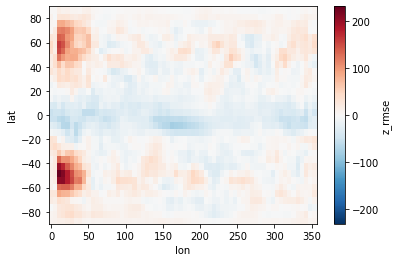

In [20]:
(rmse_np - rmse_p).z_rmse.plot()

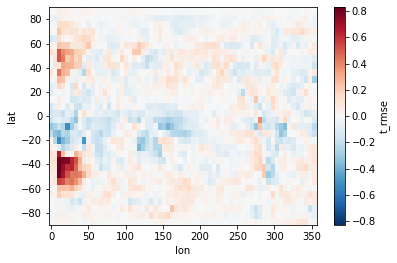

In [21]:
(rmse_np - rmse_p).t_rmse.plot()

## Add constants

In [5]:
hs = [read_pickle(
    f'/home/stephan/data/myWeatherBench/predictions/saved_models/{h}_history.pkl')
     for h in ['10-big_fc', '11-add_orography', '12-add_lat', '13-add_lsm']]

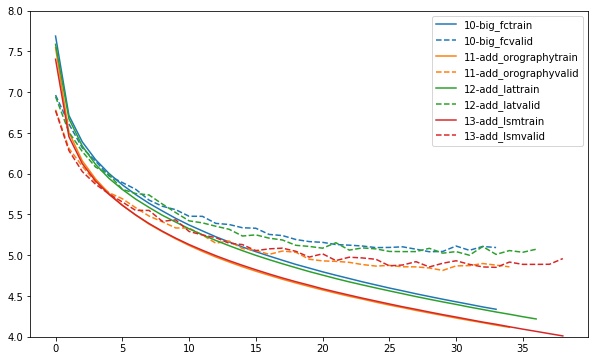

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for h, name, c in zip(hs, ['10-big_fc', '11-add_orography', '12-add_lat', '13-add_lsm'], 
                      sns.color_palette()):
    plot_hist(h, ax, (4, 8), name, valid=False, c=c)
    plot_hist(h, ax, (4, 8), name, train=False, c=c, ls='--')

## Resnet

In [5]:
datadir = '/data/stephan/WeatherBench/5.625deg/'

In [6]:
var_dict = {
    'geopotential': ('z', [500]),
    'temperature': ('t', [850]),
    'constants': ['lat2d', 'orography', 'lsm']
}

In [7]:
output_vars = ['z_500', 't_850']

In [8]:
ds = xr.merge([xr.open_mfdataset(f'{datadir}/{var}/*.nc', combine='by_coords') for var in var_dict.keys()])

In [9]:
ds_train = ds.sel(time=slice('2000', '2015'))
ds_valid = ds.sel(time=slice('2016', '2016'))
ds_test = ds.sel(time=slice('2017', '2018'))

In [10]:
lead_time=72
filters = [128, 128, 128, 128, 128, 128, 2]
kernels = [5, 5, 5, 5, 5, 5, 5]
norm_subsample = 60000
data_subsample = 1
lr = 0.5e-4
batch_size = 128

In [11]:
dg_train = DataGenerator(
    ds_train, var_dict, lead_time, batch_size=batch_size, output_vars=output_vars,
    data_subsample=data_subsample, norm_subsample=norm_subsample
)
dg_valid = DataGenerator(
    ds_valid, var_dict, lead_time, batch_size=batch_size, mean=dg_train.mean, std=dg_train.std,
    shuffle=False, output_vars=output_vars
)
dg_test =  DataGenerator(
    ds_test, var_dict, lead_time, batch_size=batch_size, mean=dg_train.mean, std=dg_train.std,
    shuffle=False, output_vars=output_vars
)

DG start 01:29:14.664648
DG normalize 01:29:14.703427
DG load 01:29:17.924511
Loading data into RAM
DG done 01:29:33.007678
DG start 01:29:33.007941
DG normalize 01:29:33.021864
DG load 01:29:33.028416
Loading data into RAM
DG done 01:29:34.233335
DG start 01:29:34.233578
DG normalize 01:29:34.248894
DG load 01:29:34.255331
Loading data into RAM
DG done 01:29:36.126415


In [145]:
class ChannelSlice(tf.keras.layers.Layer):

    def __init__(self, n_out, **kwargs):
        self.n_out = n_out
        super().__init__(**kwargs)

    def _slice(self, inputs):
        # Input: [samples, lat, lon, filters]
        return inputs[..., :self.n_out]

    def __call__(self, inputs):
        out = Lambda(self._slice)(inputs)
        return out

In [49]:
def convblock(inputs, filters, kernel=3, stride=1, bn_position=None, l2=0,
              use_bias=True, dropout=0):
    x = inputs
    if bn_position == 'pre': x = BatchNormalization()(x)
    x = PeriodicConv2D(filters, kernel)(x)
    if bn_position == 'mid': x = BatchNormalization()(x)
    x = ReLU()(x)
    if bn_position == 'post': x = BatchNormalization()(x)
    if dropout > 0: x = Dropout(dropout)(x)
    return x

In [50]:
def build_resnet(filters, kernels, input_shape, bn_position=None, use_bias=True, l2=0,
                 skip=True, dropout=0):
    x = input = Input(shape=input_shape)
    # First conv block to get up to shape
    x = convblock(
        x, filters[0], kernels[0], bn_position=bn_position, l2=l2, use_bias=use_bias,
        dropout=dropout
    )
    
    # Resblocks
    for f, k in zip(filters[1:-1], kernels[1:-1]):
        y = x
        for _ in range(2):
            x = convblock(
                x, f, k, bn_position=bn_position, l2=l2, use_bias=use_bias,
                dropout=dropout
            )
        if skip: x = Add()([y, x])
    
    # Final convolution
    output = PeriodicConv2D(filters[-1], kernels[-1], kernel_regularizer=regularizers.l2(l2))(x)
    return keras.models.Model(input, output)

In [51]:
model = build_resnet(filters=[128, 128, 128, 128, 128, 128, 128, 128, 2], 
                     kernels=[7, 3, 3, 3, 3, 3, 3, 3, 3], 
                     input_shape=(32, 64, len(dg_train.data.level)),
                    bn_position='mid', skip=False, dropout=0.1)

In [52]:
model.compile(keras.optimizers.Adam(lr), 'mse')

In [53]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 32, 64, 5)         0         
_________________________________________________________________
lambda_81 (Lambda)           (None, 38, 70, 5)         0         
_________________________________________________________________
periodic_conv2d_81 (Periodic (None, 32, 64, 128)       31488     
_________________________________________________________________
batch_normalization_44 (Batc (None, 32, 64, 128)       512       
_________________________________________________________________
re_lu_75 (ReLU)              (None, 32, 64, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 64, 128)       0         
_________________________________________________________________
lambda_82 (Lambda)           (None, 34, 66, 128)       0         
__________

In [46]:
from src.clr import LRFinder
lrf = LRFinder(
    dg_train.n_samples, batch_size,
    minimum_lr=1e-5, maximum_lr=1e-2,
    lr_scale='exp', save_dir='./', verbose=0)

In [47]:
model.fit_generator(dg_train, steps_per_epoch=200000, epochs=1, 
                    callbacks=[lrf])

Epoch 1/1
  1213/200000 [..............................] - ETA: 27:31:51 - loss: 34.9583

KeyboardInterrupt: 

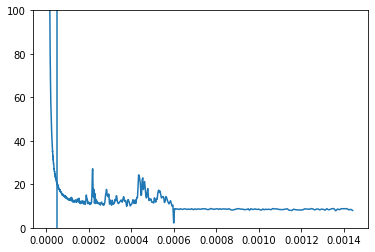

In [48]:
plt.plot(10**lrf.lrs, lrf.losses)
plt.ylim(0, 100)
# plt.xlim(0, 0.0001)
plt.axvline(0.5e-4)

## Get scores from multi-level runs

### Two level

In [97]:
var_dict = {'geopotential': ('z', [500, 850]), 'temperature': ('t', [500, 850]), 'constants': ['lsm','orography','lat2d']}
output_vars =  ['z_500', 't_850']
filters =  [128, 128, 128, 128, 128, 128, 2]
kernels =  [5, 5, 5, 5, 5, 5, 5]
lead_time =  72
norm_subsample = 60000

In [98]:
ds = xr.merge([xr.open_mfdataset(f'{datadir}/{var}/*.nc', combine='by_coords') for var in var_dict.keys()])

In [99]:
ds_train = ds.sel(time=slice('1979', '2015'))
ds_valid = ds.sel(time=slice('2016', '2016'))
ds_test = ds.sel(time=slice('2017', '2018'))

In [100]:
dg_train = DataGenerator(
    ds_train, var_dict, lead_time, batch_size=batch_size, output_vars=output_vars,
    data_subsample=data_subsample, norm_subsample=norm_subsample
)
dg_test =  DataGenerator(
    ds_test, var_dict, lead_time, batch_size=batch_size, mean=dg_train.mean, std=dg_train.std,
    shuffle=False, output_vars=output_vars
)

DG start 21:05:35.637813
DG normalize 21:05:35.657152
DG load 21:05:57.243387
Loading data into RAM
DG done 21:12:45.158860
DG start 21:12:45.190892
DG normalize 21:12:45.207618
DG load 21:12:45.217415
Loading data into RAM
DG done 21:12:48.148004


In [101]:
model = build_cnn(filters, kernels, 
                  input_shape=(32, 64, len(dg_train.data.level)))

In [102]:
model.compile('adam', 'mse')

In [103]:
model.load_weights(
    '/home/stephan/data/myWeatherBench/predictions/saved_models//15_two_level.h5')

In [104]:
preds = create_predictions(model, dg_test)

In [106]:
z500_valid = load_test_data(f'{datadir}geopotential_500', 'z')
t850_valid = load_test_data(f'{datadir}temperature_850', 't')

In [107]:
print(compute_weighted_rmse(preds.z, z500_valid).load())

print(compute_weighted_rmse(preds.t, t850_valid).load())

<xarray.DataArray 'z_rmse' ()>
array(555.24154875)
Coordinates:
    level    int32 500
<xarray.DataArray 't_rmse' ()>
array(2.55548829)
Coordinates:
    level    int32 850


### Three level

In [108]:
var_dict = {'geopotential': ('z', [200, 500, 850]), 'temperature': ('t', [200, 500, 850]), 'constants': ['lsm','orography','lat2d']}

In [109]:
dg_train = DataGenerator(
    ds_train, var_dict, lead_time, batch_size=batch_size, output_vars=output_vars,
    data_subsample=data_subsample, norm_subsample=norm_subsample
)
dg_test =  DataGenerator(
    ds_test, var_dict, lead_time, batch_size=batch_size, mean=dg_train.mean, std=dg_train.std,
    shuffle=False, output_vars=output_vars
)

DG start 21:19:44.336098
DG normalize 21:19:44.355051
DG load 21:21:52.063845
Loading data into RAM
DG done 21:31:52.324262
DG start 21:31:53.155549
DG normalize 21:31:53.430830
DG load 21:31:53.455318
Loading data into RAM
DG done 21:32:00.698698


In [110]:
model = build_cnn(filters, kernels, 
                  input_shape=(32, 64, len(dg_train.data.level)))

In [111]:
model.compile('adam', 'mse')

In [112]:
model.load_weights(
    '/home/stephan/data/myWeatherBench/predictions/saved_models//16_three_level.h5')

In [113]:
preds = create_predictions(model, dg_test)

In [114]:
print(compute_weighted_rmse(preds.z, z500_valid).load())

print(compute_weighted_rmse(preds.t, t850_valid).load())

<xarray.DataArray 'z_rmse' ()>
array(543.86886498)
Coordinates:
    level    int32 500
<xarray.DataArray 't_rmse' ()>
array(2.53358058)
Coordinates:
    level    int32 850


### Five level

In [125]:
var_dict = {'geopotential': ('z', [100, 200, 500, 850, 1000]), 'temperature': ('t', [100, 200, 500, 850, 1000]), 'constants': ['lsm','orography','lat2d']}

In [ ]:
dg_train = DataGenerator(
    ds_train, var_dict, lead_time, batch_size=batch_size, output_vars=output_vars,
    data_subsample=data_subsample, norm_subsample=norm_subsample
)
dg_test =  DataGenerator(
    ds_test, var_dict, lead_time, batch_size=batch_size, mean=dg_train.mean, std=dg_train.std,
    shuffle=False, output_vars=output_vars
)

DG start 11:11:30.828213
DG normalize 11:11:30.867317
DG load 11:13:42.349267
Loading data into RAM


In [131]:
model = build_cnn(filters, kernels, 
                  input_shape=(32, 64, len(dg_train.data.level)))

In [132]:
model.compile('adam', 'mse')

In [133]:
model.load_weights(
    '/home/stephan/data/myWeatherBench/predictions/saved_models//17_five_level.h5')

In [136]:
preds = create_predictions(model, dg_test)

In [137]:
print(compute_weighted_rmse(preds.z, z500_valid).load())

print(compute_weighted_rmse(preds.t, t850_valid).load())

<xarray.DataArray 'z_rmse' ()>
array(537.44446366)
Coordinates:
    level    int32 500
<xarray.DataArray 't_rmse' ()>
array(2.51349293)
Coordinates:
    level    int32 850


## Check tisr normalizations

In [8]:
tisr = xr.open_mfdataset(f'{DATADIR}/toa_incident_solar_radiation/*.nc').tisr

/home/stephan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/home/stephan/miniconda3/lib/python3.6/site-packages/xarray/backends/api.py:931: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


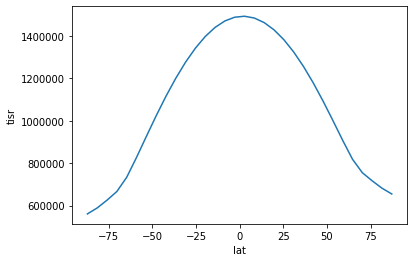

In [9]:
tisr[::60000].mean(('time', 'lon')).plot()

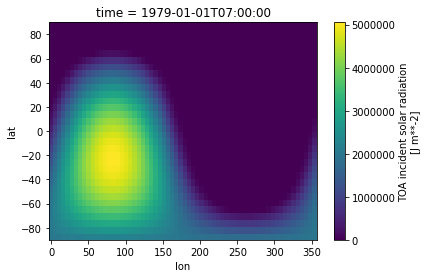

In [10]:
tisr[0].plot()

In [12]:
var_dict = {'geopotential': ('z', [500]), 'temperature': ('t', [850]), 
                      'toa_incident_solar_radiation': ('tisr', None), 
                      'constants': ['lsm','orography','lat2d']}

In [13]:
output_vars = ['z_500', 't_850']

In [19]:
norm_subsample = 60000
batch_size = 128
lead_time = 72

In [38]:
ds = [xr.open_mfdataset(f'{DATADIR}/{var}/*.nc', combine='by_coords') for var in var_dict.keys()]

In [48]:
ds[2].isel(time=0).tisr.values

array([[2008593.6, 2030433.8, 2052196.6, ..., 1941529.4, 1963678.1,
        1986058.5],
       [2042009.8, 2108070.2, 2172664.2, ..., 1841820.4, 1908189.6,
        1975176. ],
       [2055900.9, 2165410. , 2272372.5, ..., 1724284.1, 1834333.6,
        1945231.9],
       ...,
       [      0. ,       0. ,       0. , ...,       0. ,       0. ,
              0. ],
       [      0. ,       0. ,       0. , ...,       0. ,       0. ,
              0. ],
       [      0. ,       0. ,       0. , ...,       0. ,       0. ,
              0. ]], dtype=float32)

In [53]:
tisr = ds[2]

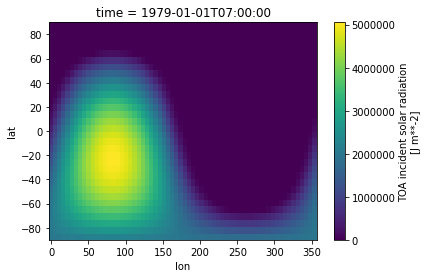

In [54]:
tisr.tisr.isel(time=0).plot()

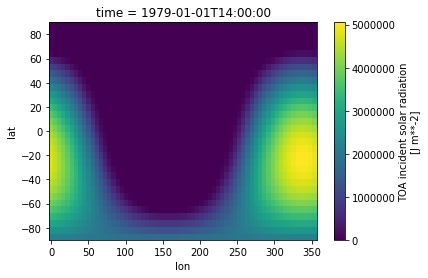

In [58]:
tisr.tisr.isel(time=7).plot()

In [55]:
z = ds[0]

In [56]:
tisr

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 350633)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 1979-01-01T07:00:00 ... 2018-12-31T23:00:00
Data variables:
    tisr     (time, lat, lon) float32 dask.array<chunksize=(8753, 32, 64), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2019-12-07 20:42:10 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...

In [57]:
z

<xarray.Dataset>
Dimensions:  (lat: 32, level: 11, lon: 64, time: 350640)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * level    (level) int32 1 10 100 200 300 400 500 600 700 850 1000
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
Data variables:
    z        (time, level, lat, lon) float32 dask.array<chunksize=(8760, 11, 32, 64), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2019-11-10 20:33:23 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...

In [59]:
ds2 = xr.merge(ds, fill_value=0)

In [60]:
ds2.isel(time=0).tisr.values

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [21]:
ds_train = ds.sel(time=slice('1979', '2015'))
ds_valid = ds.sel(time=slice('2016', '2016'))
ds_test = ds.sel(time=slice('2017', '2018'))

In [37]:
ds_train.z.isel(time=0).values

array([[[ 4.97916875e+05,  4.97901469e+05,  4.97878312e+05, ...,
          4.97978562e+05,  4.97955438e+05,  4.97940000e+05],
        [ 4.97223000e+05,  4.97192156e+05,  4.97184438e+05, ...,
          4.97500562e+05,  4.97384875e+05,  4.97292375e+05],
        [ 4.96382625e+05,  4.96166750e+05,  4.95981688e+05, ...,
          4.96583062e+05,  4.96544500e+05,  4.96505969e+05],
        ...,
        [ 4.24433719e+05,  4.24819219e+05,  4.25505406e+05, ...,
          4.23863188e+05,  4.23940281e+05,  4.24194719e+05],
        [ 4.22444562e+05,  4.22806938e+05,  4.23292656e+05, ...,
          4.21858625e+05,  4.21981969e+05,  4.22174719e+05],
        [ 4.23924875e+05,  4.24055938e+05,  4.24210125e+05, ...,
          4.23639594e+05,  4.23716688e+05,  4.23809219e+05]],

       [[ 3.14775656e+05,  3.14783375e+05,  3.14783375e+05, ...,
          3.14767938e+05,  3.14767938e+05,  3.14775656e+05],
        [ 3.14274500e+05,  3.14289938e+05,  3.14313062e+05, ...,
          3.14259094e+05,  3.14243688e

In [64]:
ds_train.z.isel(time=0).mean().compute()

<xarray.DataArray 'z' ()>
array(121975.55, dtype=float32)
Coordinates:
    time     datetime64[ns] 1979-01-01

In [31]:
dg_train = DataGenerator(
    ds_train, var_dict, lead_time, batch_size=batch_size, output_vars=output_vars,
    data_subsample=1, norm_subsample=norm_subsample,
    load=False
)

DG start 17:46:49.381015
DG normalize 17:46:49.421127


/home/stephan/miniconda3/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


> /home/stephan/repositories/myWeatherBench/devlog/src/data_generator.py(73)__init__()
-> self.data = (self.data - self.mean) / self.std


(Pdb)  self.data.isel(time=slice(0, None, norm_subsample)).mean(             ('time', 'lat', 'lon')).compute()


<xarray.DataArray 'z' (level: 6)>
array([5.40718465e+04, 2.74390602e+02, 1.05164966e+06, 3.37078289e-01,
       3.79497583e+02, 0.00000000e+00])
Coordinates:
  * level        (level) int64 500 850 1 1 1 1
    level_names  (level) <U9 'z_500' 't_850' 'tisr' 'lsm' 'orography' 'lat2d'


(Pdb)  self.data.isel(time=slice(0, None, norm_subsample)).std(             ('time', 'lat', 'lon')).compute()


/home/stephan/miniconda3/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'z' (level: 6)>
array([3.40038890e+03, 1.58818224e+01, 1.42143234e+06, 4.59003773e-01,
       8.59872249e+02, 5.19361462e+01])
Coordinates:
  * level        (level) int64 500 850 1 1 1 1
    level_names  (level) <U9 'z_500' 't_850' 'tisr' 'lsm' 'orography' 'lat2d'


(Pdb)  self.data.isel(level=2)


<xarray.DataArray 'z' (time: 324336, lat: 32, lon: 64)>
dask.array<getitem, shape=(324336, 32, 64), dtype=float64, chunksize=(8784, 32, 64), chunktype=numpy.ndarray>
Coordinates:
  * lon          (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat          (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time         (time) datetime64[ns] 1979-01-01 ... 2015-12-31T23:00:00
    level        int64 1
    level_names  <U9 'tisr'


(Pdb)  self.data.isel(level=2, time=0).values


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])


(Pdb)  q


BdbQuit: 

In [24]:
dg_train.std

<xarray.DataArray 'z' (level: 6)>
array([3.40038890e+03, 1.58818224e+01, 1.42143234e+06, 4.59003773e-01,
       8.59872249e+02, 5.19361462e+01])
Coordinates:
  * level        (level) int64 500 850 1 1 1 1
    level_names  (level) <U9 'z_500' 't_850' 'tisr' 'lsm' 'orography' 'lat2d'

In [30]:
dg_train.data.isel(level=2, time=1).values

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

## UNET

In [5]:
datadir = '/data/stephan/WeatherBench/5.625deg/'

In [6]:
var_dict = {
    'geopotential': ('z', [500]),
    'temperature': ('t', [850]),
    'constants': ['lat2d', 'orography', 'lsm']
}

In [7]:
output_vars = ['z_500', 't_850']

In [8]:
ds = xr.merge([xr.open_mfdataset(f'{datadir}/{var}/*.nc', combine='by_coords') for var in var_dict.keys()])

In [9]:
ds_train = ds.sel(time=slice('2015', '2015'))
ds_valid = ds.sel(time=slice('2016', '2016'))
ds_test = ds.sel(time=slice('2017', '2018'))

In [10]:
lead_time=72
filters = [128, 128, 128, 128, 128, 128, 2]
kernels = [5, 5, 5, 5, 5, 5, 5]
norm_subsample = 60000
data_subsample = 1
lr = 0.5e-4
batch_size = 128

In [11]:
dg_train = DataGenerator(
    ds_train, var_dict, lead_time, batch_size=batch_size, output_vars=output_vars,
    data_subsample=data_subsample, norm_subsample=norm_subsample
)
dg_valid = DataGenerator(
    ds_valid, var_dict, lead_time, batch_size=batch_size, mean=dg_train.mean, std=dg_train.std,
    shuffle=False, output_vars=output_vars
)
dg_test =  DataGenerator(
    ds_test, var_dict, lead_time, batch_size=batch_size, mean=dg_train.mean, std=dg_train.std,
    shuffle=False, output_vars=output_vars
)

DG start 05:18:33.407741
DG normalize 05:18:33.440066
DG load 05:18:44.158414
Loading data into RAM
DG done 05:18:45.409958
DG start 05:18:45.410192
DG normalize 05:18:45.423887
DG load 05:18:45.431173
Loading data into RAM
DG done 05:18:47.047908
DG start 05:18:47.048193
DG normalize 05:18:47.064181
DG load 05:18:47.070876
Loading data into RAM
DG done 05:18:49.243964


In [ ]:
class PeriodicUpsample()

In [21]:
def build_unet(input_shape, n_layers, filters_start, channels_out, kernel=3, skip=True, 
               res=False, l2=0):
    x = input = Input(shape=input_shape)
    filters = filters_start
    
    # Down
    down_layers = []
    for i in range(n_layers):
        x = resblock(x, filters, kernel, res=res, l2=l2)
        down_layers.append(x)
        x = MaxPooling2D(2, 2)(x)
        filters *= 2
    
    # Smallest level
    x = resblock(x, filters, kernel, res=res, l2=l2)
    
    # Up
    for dl in reversed(down_layers):
        filters //= 2
        x = Conv2DTranspose(filters, 2, 2, padding='same')(x)
        if skip: x = concatenate([x, dl])
        x = resblock(x, filters, kernel, res=res, l2=l2)
    
    x = PeriodicConv2D(channels_out, kernel, kernel_regularizer=regularizers.l2(l2))(x)
    return keras.models.Model(input, x)
        

In [22]:
X, y = dg_train[0]; X.shape, y.shape

((128, 32, 64, 5), (128, 32, 64, 2))

In [25]:
unet = build_unet(input_shape=(32, 64, 5,), n_layers=2, filters_start=4, channels_out=2, skip=True)

In [26]:
unet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 64, 5)    0                                            
__________________________________________________________________________________________________
lambda_22 (Lambda)              (None, 34, 66, 5)    0           input_3[0][0]                    
__________________________________________________________________________________________________
periodic_conv2d_22 (PeriodicCon (None, 32, 64, 4)    184         lambda_22[0][0]                  
__________________________________________________________________________________________________
re_lu_20 (ReLU)                 (None, 32, 64, 4)    0           periodic_conv2d_22[0][0]         
__________________________________________________________________________________________________
lambda_23 

In [33]:
# from IPython.display import SVG
# from tensorflow.keras.utils import plot_model

# plot_model(unet, 'unet.png')